In [1]:
# =======
# imports
# =======
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
import shapely

The goal is to estimate the current grid extent and then project its expansion up to 2050 according to the WTP.

# Current grid extension

To estimate current (2010) grid extension we calculate a buffer around the existing transmission lines (afretep_etrs_transmission) that contains the number of people that currently have access to electricity (WB data). Expectation is that the size of the buffer will be different for each country. To start off, in QGIS we import the gridlines file (afretep_etrs_transmission.shp), dissolve it, and save it as grid_dissolved.shp. Then we follow these steps:   

1. Create a vector layer containing all grid-lines per country (geopandas)

2. Create buffer zones at different distances (still without differentiating per country) and count how many people there are in the buffers (QGIS)

3. Compare with electricity access per country from WB. For each country, identify buffer range that best fits current access data. (geopandas) 

4. Iteratively refine the buffer areas, and make them country specific (geopandas & QGIS)


## Country grid

In this step we use geopandas to break the dissolved gridlines vector layer into country sets, and export them to a new vector layer called country_grid.shp. In the attribute table of this new layer there will be the ID of the polygons from our original country-borders shapefile, the country name and the geometry. 

(Before we do so, because it turns out are 3 countries that contain invalid points, in QGIS we manualy correct for this - i.e. remove the invalid points, and save a corrected copy of the country border shapefile.)

In [7]:
gis_dir = "C:\\Users\\dallalongaf\\OneDrive - TNO\\work\\2016 02 - TransRisk\\4 - energy access\\AFR_alt\\gis_layers\\on-grid_access\\"

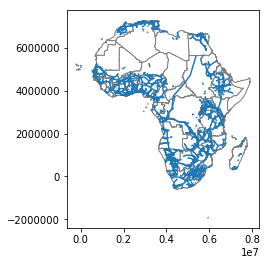

In [3]:
# vector layers
# country borders (corrected):
afr = gpd.read_file(gis_dir+"afretep_etrs_countries_corrected.shp")
# dissolved grid-lines (created with QGIS from original gridlines layer)
grid = gpd.read_file(gis_dir+"grid_dissolved.shp")
# let's plot them
ax = afr.plot(color='white', edgecolor='grey')
grid.plot(ax=ax)

In [4]:
# Create a new geodataframe with polygon ID and country name from the afr layer
grid762 = afr
to_drop = [c for c in afr.columns if c not in ['ID','COUNTRY', 'geometry']]
grid762 = grid762.drop(to_drop, axis=1)
grid762.head()

,ID,COUNTRY,geometry
0,1,Algeria,"POLYGON ((1894589.42156076 6093196.823427028, ..."
1,2,Angola,"POLYGON ((3809405.5247603 2283690.127493567, 3..."
2,3,Angola,"POLYGON ((3744504.513407562 2674551.841173306,..."
3,4,Angola,"POLYGON ((3650051.721446254 1343900.192709396,..."
4,5,Angola,"POLYGON ((3755607.506678306 2543061.0734161, 3..."


In [5]:
# Now we need to fill the 'geometry' column with 
# the portion of gridlines contained in each country

# Initiate an empty list
geos = []
# loop over all (762) indexes
for idx in afr.index:
    # print a marker every 100 elements to check progress
    if idx/100 == idx//100:
        print(idx)
    # take a slice of afr df containing only relevant idx...
    gdf = afr[afr.index == idx].reset_index()
    # if geometry is valid, intersect with gridlines and append as GeometryCollection, ...
    if gdf.geometry.is_valid[0]:
        geos.append(grid.intersection(gdf).values[0])
    # ... otherwise append empty GeometryCollection object
    else:
        geos.append(shapely.geometry.GeometryCollection())
    #
    # Note that this last if...else statement will exclude some countries if 
    # they are not valid polygons!! E.g. polygons with self-intersection.

0
100
200
300
400
500
600
700


In [6]:
# Check crs is there
grid762.crs

{'a': 6378137,
 'b': 6378137,
 'lat_0': 0,
 'lon_0': 18,
 'no_defs': True,
 'proj': 'laea',
 'units': 'm',
 'x_0': 4321000,
 'y_0': 3210000}

In [7]:
# put geometries into the new gdf:
grid762.loc[:,'geometry'] = geos
grid762.set_geometry('geometry')
grid762 = grid762[-grid762.geometry.is_empty].reset_index().drop('index',axis=1)
grid762.head()

,ID,COUNTRY,geometry
0,1,Algeria,(LINESTRING (2930978.789678263 6820043.8091386...
1,2,Angola,(LINESTRING (3687515.311713001 1521170.9859224...
2,3,Angola,LINESTRING (3677895.79200978 2591628.267472052...
3,20,Benin,(LINESTRING (2578005.695706695 4080307.4511860...
4,21,Botswana,(LINESTRING (5110153.142133479 501730.68208632...


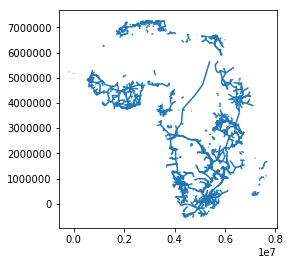

In [8]:
# plot to check that it worked
grid762.plot()

In [16]:
# Most items in the gdf are lines or MultiLine objects. 
# One of the items is a GeometryCollection containing a Point and some lines.
grid762[grid762.geometry.type == 'GeometryCollection']

,ID,COUNTRY,geometry
43,626,Nigeria,"(POINT (2809056.999796253 4672251.667803846), ..."


In [10]:
# The presence of a point somehow screws up the system and doesn't allow
# me to export the gdf to a shapefile 
#grid762.to_file(gis_dir+"country_grid.shp")

In [21]:
# As a workaround we remove the Point from the geometry of item 43
# (a point is not so important for our purposes anyway)

new_geometry = []
for i in grid762.index:
    g = grid762.loc[i,'geometry']
    if i != 43:
        new_geometry.append(g)
    else: 
        new_geometry.append(g-g[0]) # remove the point, i.e. g[0]
grid762.loc[:,'geometry'] = new_geometry
grid762.set_geometry('geometry')
grid762.head()

,ID,COUNTRY,geometry
0,1,Algeria,(LINESTRING (2930978.789678263 6820043.8091386...
1,2,Angola,(LINESTRING (3687515.311713001 1521170.9859224...
2,3,Angola,LINESTRING (3677895.79200978 2591628.267472052...
3,20,Benin,(LINESTRING (2578005.695706695 4080307.4511860...
4,21,Botswana,(LINESTRING (5110153.142133479 501730.68208632...


In [6]:
#grid762 = gpd.read_file(gis_dir+"country_grid.shp")
#missing_countries = ['Djibouti', 'Equatorial Guinea', 'Sierra Leone', 'Somalia']

In [5]:
# Some countries are missing
missing_countries = ['Djibouti', 'Equatorial Guinea', 'Sierra Leone', 'Somalia']
grid762[grid762.COUNTRY.isin(missing_countries)]

,ID,COUNTRY,geometry


In [6]:
# let's include empty slots in grid762 for the missing countries
df = afr[afr.COUNTRY.isin(missing_countries)].loc[:,['ID','COUNTRY']]
# For each country there are several polygons. We want to keep only 
# the first polygon (the main body of the country)
ids = []
for c in missing_countries:
    ids.append(min(df[df.COUNTRY==c].ID))
# merge into grid762
grid762 = grid762.merge(df[df.ID.isin(ids)],on=['ID','COUNTRY'],how='outer')
grid762[grid762.COUNTRY.isin(missing_countries)]

,ID,COUNTRY,geometry
57,64,Djibouti,NaN
58,166,Equatorial Guinea,NaN
59,642,Sierra Leone,NaN
60,673,Somalia,NaN


Now we have fill the geometry
We take gridlines for these countries from another source (https://energydata.info/):
In QGIS we save them withe the right projection (NOTE: files ending with _grid are the originals). We also clip the ines that extend beyond country boundaires, and get rid of lines which are marked as 'planned' or as built after 2010. (For Somalia there seem to be no existing gridlines, so we take the planned ones.) Finally we dissolve the segments into one single object per country. 

Then we import the resulting vector layers here:

In [7]:
dj = gpd.read_file(gis_dir+"extra_grid\\Djibouti_prj.shp")
eg = gpd.read_file(gis_dir+"extra_grid\\EquatorialGuinea_prj.shp")
sl = gpd.read_file(gis_dir+"extra_grid\\SierraLeone_prj.shp")
so = gpd.read_file(gis_dir+"extra_grid\\Somalia_prj.shp")

In [10]:
# In order to merge their geometries into grid762 we create a new geometry column for hte whole gdf: 
# (doing them one by one gives errors when trying to replace the NaNs with MultiLineString objects)
new_geometry = []
for i in grid762.index:
    g = grid762.loc[i,'geometry']
    if grid762.loc[:, 'geometry'].isnull()[i]: 
        # add the geom for each of the 4 countries
        if grid762.loc[i,'COUNTRY']=='Djibouti':
            new_geometry.append(dj.loc[0,'geometry'])
        elif grid762.loc[i,'COUNTRY']=='Sierra Leone':
            new_geometry.append(sl.loc[0,'geometry'])
        elif grid762.loc[i,'COUNTRY']=='Somalia':
            new_geometry.append(so.loc[0,'geometry'])
        elif grid762.loc[i,'COUNTRY']=='Equatorial Guinea':
            new_geometry.append(eg.loc[0,'geometry'])
    else: 
        new_geometry.append(g) # keep the old geometry
grid762.loc[:,'geometry'] = new_geometry
grid762.set_geometry('geometry')
grid762.tail()

,ID,COUNTRY,geometry
56,762,Zimbabwe,(LINESTRING (5444927.741589094 1041686.0122403...
57,64,Djibouti,LINESTRING (7020406.142348779 4462695.37888769...
58,166,Equatorial Guinea,(LINESTRING (3398655.384256097 3328936.3722093...
59,642,Sierra Leone,LINESTRING (1080703.95989528 4253278.897668642...
60,673,Somalia,(LINESTRING (7088094.447033701 4303785.3866424...


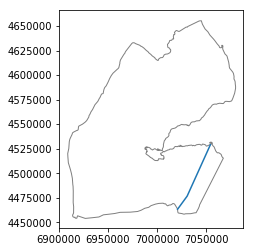

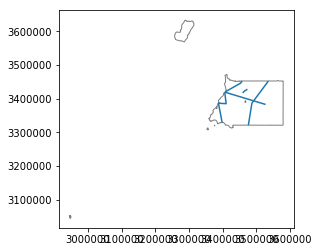

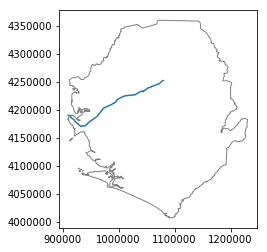

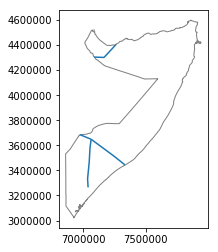

In [11]:
for c in missing_countries:
    ax = afr[afr.COUNTRY==c].plot(color='white', edgecolor='grey')
    grid762.loc[grid762[grid762.COUNTRY==c].index,'geometry'].plot(ax=ax)

In [12]:
# Now we can export to a new shapefile for further QGIS processing
grid762.to_file(gis_dir+"country_grid.shp")

## Buffers

Buffer layers at 1, 3, 5, 7, 9 20, 30 and 50 km distance around the grid created in QGIS. Names b_1k.shp, etc. Zonal Statistics (sum pop_prj.tif) have been run on each buffer layer to estimate how many people fall in the buffer zone. 

## Current grid extension - iteration 0

We now import the new buffer layers in geopandas and compare with electricity access figures from the WB for the year 2010. Our working assumption is that in 2010 most of electricity access happens through the grid, hence we want our buffers to contain the whole of the connected population in each country.  

In [4]:
# We will need the wtp_vec layer from the off-grid analysis
wtp_dir = "C:\\Users\\dallalongaf\\OneDrive - TNO\\work\\2016 02 - TransRisk\\4 - energy access\\AFR\\gis_layers\\off-grid_access\\"
# And the energy access data
data_dir = "C:\\Users\\dallalongaf\\OneDrive - TNO\\work\\2016 02 - TransRisk\\4 - energy access\\AFR\\code\\input_data\\"

In [5]:
# Let's first import all the buffer layers
b_1k = gpd.read_file(gis_dir+"buffers\\b_1k.shp")
b_3k = gpd.read_file(gis_dir+"buffers\\b_3k.shp")
b_5k = gpd.read_file(gis_dir+"buffers\\b_5k.shp")
b_7k = gpd.read_file(gis_dir+"buffers\\b_7k.shp")
b_9k = gpd.read_file(gis_dir+"buffers\\b_9k.shp")
b_20k = gpd.read_file(gis_dir+"buffers\\b_20k.shp")
b_30k = gpd.read_file(gis_dir+"buffers\\b_30k.shp")
b_50k = gpd.read_file(gis_dir+"buffers\\b_50k.shp")

In [6]:
# Make country-level overview
cb_1k = b_1k.groupby('COUNTRY').sum()
cb_3k = b_3k.groupby('COUNTRY').sum()
cb_5k = b_5k.groupby('COUNTRY').sum()
cb_7k = b_7k.groupby('COUNTRY').sum()
cb_9k = b_9k.groupby('COUNTRY').sum()
cb_20k = b_20k.groupby('COUNTRY').sum()
cb_30k = b_30k.groupby('COUNTRY').sum()
cb_50k = b_50k.groupby('COUNTRY').sum()
cb_1k.head()

,1k_popsum
COUNTRY,
Algeria,6576129.0
Angola,1520062.0
Benin,2744992.0
Botswana,394072.0
Burkina Faso,2694399.0


In [8]:
# Concatenate all buffer data into one single DF cb (for country buffers):
cb = pd.concat([cb_1k,cb_3k,cb_5k,cb_7k,cb_9k,cb_20k,cb_30k,cb_50k],axis=1).reset_index()
cols = ['COUNTRY']
for c in cb.columns[1:]:
    cols.append(c[:len(c)-8])

cb.columns = cols
cb.head()


,COUNTRY,1,3,5,7,9,20,30,50
0,Algeria,6576129.0,14186848.0,17789100.0,19838273.0,20874753.0,24600942.0,26356077.0,28471813.0
1,Angola,1520062.0,3486985.0,4457113.0,4944396.0,5388374.0,7500545.0,9060048.0,11766469.0
2,Benin,2744992.0,4822886.0,5779833.0,6445103.0,6940081.0,8891085.0,10353078.0,13030000.0
3,Botswana,394072.0,803398.0,989693.0,1088972.0,1157404.0,1424532.0,1599342.0,2036910.0
4,Burkina Faso,2694399.0,5057232.0,6063797.0,6730747.0,7399939.0,10529911.0,12932466.0,16670403.0


In [9]:
# Import the wtp_vec file, where we have already counted the number 
# of people in each polygon. This is stored in column 'popsum'. 
wtp = gpd.read_file(wtp_dir+"wtp_vec.shp")
wtp = wtp.replace('Guinea-Bissau', 'Guinea Bissau')
# Again group by country, and only select columns 'COUNTRY' and 'popsum':
cwtp = wtp.groupby('COUNTRY').sum().reset_index()[['COUNTRY','popsum']]
# Then rename 'popsum' to 'pop_raster' to avoid confusion:
cwtp.columns = ['COUNTRY','pop_raster']
cwtp.head()

,COUNTRY,pop_raster
0,Algeria,2.505002e+07
1,Angola,1.552295e+07
2,Benin,8.054520e+06
3,Botswana,1.336563e+06
4,Burkina Faso,1.290668e+07


In [10]:
# Merge total pop per country (from raster layer)
cb = cb.merge(cwtp,on='COUNTRY',how='outer')
cb.head()

,COUNTRY,1,3,5,7,9,20,30,50,pop_raster
0,Algeria,6576129.0,14186848.0,17789100.0,19838273.0,20874753.0,24600942.0,26356077.0,28471813.0,2.505002e+07
1,Angola,1520062.0,3486985.0,4457113.0,4944396.0,5388374.0,7500545.0,9060048.0,11766469.0,1.552295e+07
2,Benin,2744992.0,4822886.0,5779833.0,6445103.0,6940081.0,8891085.0,10353078.0,13030000.0,8.054520e+06
3,Botswana,394072.0,803398.0,989693.0,1088972.0,1157404.0,1424532.0,1599342.0,2036910.0,1.336563e+06
4,Burkina Faso,2694399.0,5057232.0,6063797.0,6730747.0,7399939.0,10529911.0,12932466.0,16670403.0,1.290668e+07


In [11]:
# Normalize (i.e. express all cols except for pop_raster as percentages.)
cb_norm = pd.DataFrame(index=cb.index, columns=cb.columns, data=0)
cb_norm.loc[:,['COUNTRY','pop_raster']] = cb.loc[:,['COUNTRY','pop_raster']]
for c in cb.columns[1:9]:
    cb_norm.loc[:,c] = 100 * cb.loc[:,c] / cb.loc[:,'pop_raster']
cb_norm = cb_norm.fillna(0)
cb_norm

,COUNTRY,1,3,5,7,9,20,30,50,pop_raster
0,Algeria,26.251990,56.634076,71.014312,79.194636,83.332277,98.207271,105.213792,113.659837,2.505002e+07
1,Angola,9.792350,22.463411,28.713046,31.852158,34.712297,48.319056,58.365488,75.800449,1.552295e+07
2,Benin,34.080144,59.878006,71.758876,80.018462,86.163806,110.386280,128.537492,161.772520,8.054520e+06
3,Botswana,29.483982,60.109250,74.047613,81.475546,86.595544,106.581732,119.660802,152.399101,1.336563e+06
4,Burkina Faso,20.876007,39.183065,46.981857,52.149337,57.334188,81.584983,100.199804,129.161067,1.290668e+07
5,Burundi,1.266866,5.609075,9.479399,11.593928,14.229417,26.548285,39.899214,68.987099,7.292878e+06
6,Cameroon,30.327291,56.255446,67.497718,76.039500,83.405377,106.238429,118.726373,138.524656,1.718269e+07
7,Cape Verde,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
8,Central African Republic,3.324903,9.126759,12.869769,18.827636,21.523344,28.529450,34.473153,43.691452,3.417062e+06
9,Chad,0.981943,3.842714,7.886645,12.277252,14.460545,16.752168,18.398751,23.388959,9.362054e+06


In [12]:
# Import electricity access data [% of total pop]
acc = pd.read_excel(data_dir+"el_acc.xlsx",sheet_name="Data",skiprows=3)
acc = acc.loc[:,['COUNTRY','2010']]
acc.columns = ['COUNTRY','wb_access']
acc.head()

,COUNTRY,wb_access
0,Aruba,93.356292
1,Afghanistan,42.700000
2,Angola,33.514950
3,Albania,100.000000
4,Andorra,100.000000


In [13]:
cb_norm_wb = cb_norm.merge(acc, on='COUNTRY',how='left')
cb_norm_wb.head()

,COUNTRY,1,3,5,7,9,20,30,50,pop_raster,wb_access
0,Algeria,26.251990,56.634076,71.014312,79.194636,83.332277,98.207271,105.213792,113.659837,2.505002e+07,98.884972
1,Angola,9.792350,22.463411,28.713046,31.852158,34.712297,48.319056,58.365488,75.800449,1.552295e+07,33.514950
2,Benin,34.080144,59.878006,71.758876,80.018462,86.163806,110.386280,128.537492,161.772520,8.054520e+06,34.200000
3,Botswana,29.483982,60.109250,74.047613,81.475546,86.595544,106.581732,119.660802,152.399101,1.336563e+06,47.793114
4,Burkina Faso,20.876007,39.183065,46.981857,52.149337,57.334188,81.584983,100.199804,129.161067,1.290668e+07,13.100000


In [14]:
def find_best_fit(idx):
    """Finds the buffer range in cb_norm_wb that best matches WB energy access 2010 values."""
    # Take the difference between each column [1-50] and wb_access, 
    # put all differences in a pd.Series and sort, 
    # take the index of the first (smallest) difference --> it corresponds to the right column!
    col = pd.Series(abs(cb_norm_wb.loc[idx,[c for c in cb_norm_wb.columns if c.isnumeric()]]\
                      - cb_norm_wb.loc[idx,'wb_access'])).sort_values().index[0]
    val = cb_norm_wb.loc[idx,col]
    country = cb_norm_wb.loc[idx,'COUNTRY']
    delta = cb_norm_wb.loc[idx,col]- cb_norm_wb.loc[idx,'wb_access']
    return [country,col,val,delta]

# Put all best fits in a nested list...
best_fits = []
for i in cb_norm_wb.index:
    best_fits.append(find_best_fit(i))

# ... then turn it into a DF
best_fits_df = pd.DataFrame(best_fits)
best_fits_df.columns = ['COUNTRY','buffer_km','b_access','delta_bwb']
best_fits_df.head()

,COUNTRY,buffer_km,b_access,delta_bwb
0,Algeria,20,98.207271,-0.677701
1,Angola,9,34.712297,1.197347
2,Benin,1,34.080144,-0.119856
3,Botswana,3,60.109250,12.316137
4,Burkina Faso,1,20.876007,7.776007


In [15]:
cb_norm_wb=cb_norm_wb.merge(best_fits_df, on='COUNTRY', how='outer')

In [16]:
cb_norm_wb

,COUNTRY,1,3,5,7,9,20,30,50,pop_raster,wb_access,buffer_km,b_access,delta_bwb
0,Algeria,26.251990,56.634076,71.014312,79.194636,83.332277,98.207271,105.213792,113.659837,2.505002e+07,98.884972,20,98.207271,-0.677701
1,Angola,9.792350,22.463411,28.713046,31.852158,34.712297,48.319056,58.365488,75.800449,1.552295e+07,33.514950,9,34.712297,1.197347
2,Benin,34.080144,59.878006,71.758876,80.018462,86.163806,110.386280,128.537492,161.772520,8.054520e+06,34.200000,1,34.080144,-0.119856
3,Botswana,29.483982,60.109250,74.047613,81.475546,86.595544,106.581732,119.660802,152.399101,1.336563e+06,47.793114,3,60.109250,12.316137
4,Burkina Faso,20.876007,39.183065,46.981857,52.149337,57.334188,81.584983,100.199804,129.161067,1.290668e+07,13.100000,1,20.876007,7.776007
5,Burundi,1.266866,5.609075,9.479399,11.593928,14.229417,26.548285,39.899214,68.987099,7.292878e+06,5.300000,3,5.609075,0.309075
6,Cameroon,30.327291,56.255446,67.497718,76.039500,83.405377,106.238429,118.726373,138.524656,1.718269e+07,52.879360,3,56.255446,3.376086
7,Cape Verde,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,81.100000,1,0.000000,-81.100000
8,Central African Republic,3.324903,9.126759,12.869769,18.827636,21.523344,28.529450,34.473153,43.691452,3.417062e+06,9.800000,3,9.126759,-0.673241
9,Chad,0.981943,3.842714,7.886645,12.277252,14.460545,16.752168,18.398751,23.388959,9.362054e+06,6.400000,5,7.886645,1.486645


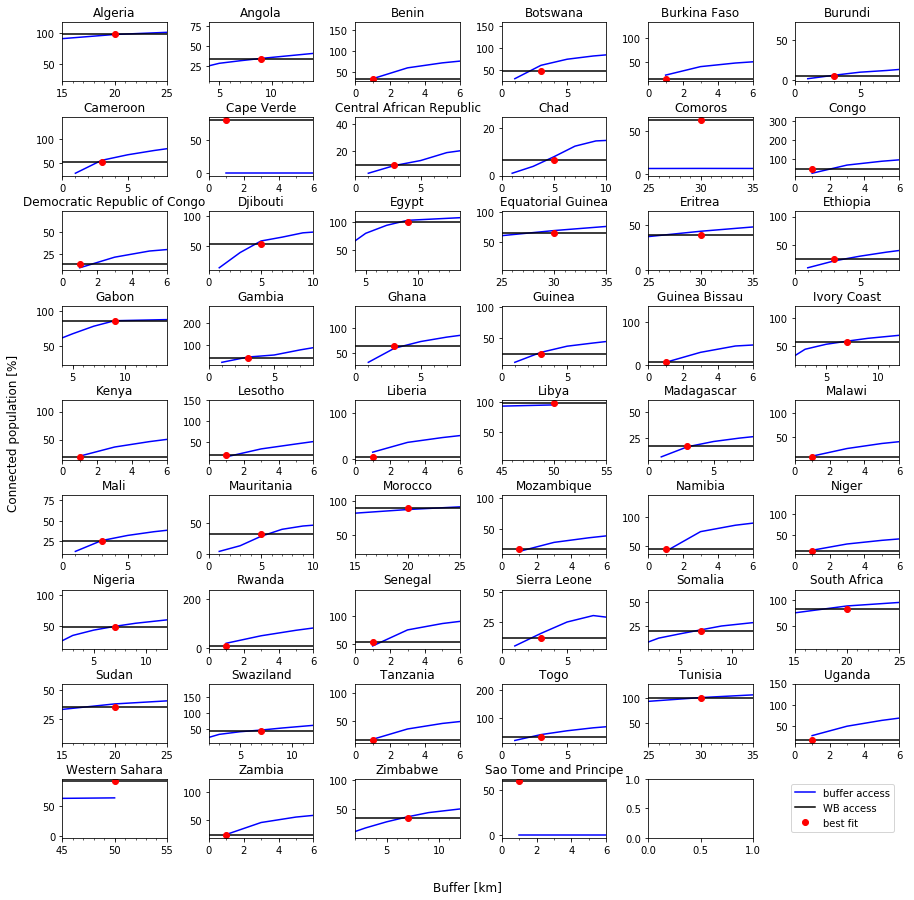

In [17]:
# Plot all current buffer access data:
# (See a couple of cells below for some more comments on how the plots are made)

fig, ax = plt.subplots(9, 6)#, sharex='col', sharey='row')
fig.set_size_inches(15,15)
fig.subplots_adjust(hspace=0.6, wspace=0.4)

cols = [c for c in cb_norm_wb.columns if c.isnumeric()]
for i in range(9):
    for j in range(6):
        idx = 6*i + j
        if idx in cb_norm_wb.index:
            # select the right index and the numeric columns and transpose
            df = cb_norm_wb.loc[idx,cols].transpose().reset_index()
        
            # calculated buffer access:
            buff,=ax[i,j].plot(df.loc[:,'index'],df.loc[:,idx],color='blue')

            # wb access as a horizontal line:
            wb=ax[i,j].axhline(cb_norm_wb.loc[idx,'wb_access'], color='black')

            # access in best_fit buffer as a red dot
            bestfit,=ax[i,j].plot(int(cb_norm_wb.loc[idx,'buffer_km']),cb_norm_wb.loc[idx,'wb_access'], 'o', color='red')

            ax[i,j].set_title(cb_norm_wb.loc[idx,'COUNTRY'])
            ax[i,j].set_xlim(max(int(cb_norm_wb.loc[idx,'buffer_km'])-5,0),int(cb_norm_wb.loc[idx,'buffer_km'])+5)
            ax[i,j].set_xticks(range(max(int(cb_norm_wb.loc[idx,'buffer_km'])-5,0),int(cb_norm_wb.loc[idx,'buffer_km'])+5),\
                               range(max(int(cb_norm_wb.loc[idx,'buffer_km'])-5,0),int(cb_norm_wb.loc[idx,'buffer_km'])+5))

# The last subplot is empty 
# We turn off its frame...
plt.gca().axis('off')
# and put a legend there
plt.legend([buff,wb,bestfit], ["buffer access","WB access","best fit"])

# overall axes titles as text objects
fig.text(0.5, 0.08, 'Buffer [km]', ha='center', va='center', fontsize=12)
fig.text(0.08, 0.5, 'Connected population [%]', ha='center', va='center', rotation='vertical', fontsize=12)


In [18]:
fig.savefig(gis_dir+"output\\current_grid_iteration_0.jpg",dpi=150)

In the plots above: 
- blue lines: % of population contained in the buffers;
- black horizontal lines: % of population with access in 2010 according to WB;
- red dots: best fit between buffer and WB access.

For most countries the best-fit point is very close to the intersection between the blue and the black lines. For some other there is a mismatch. Let's define a tolerance level (i.e. max allowed mismatch) and single out the cases beyond tolerance:

In [19]:
# define a tolerance level
# we set it at 5%:
tolerance = 5

# put all indexes of best-fits that are beyond the tolerance level in a list:
beyond_tolerance = []
for i in cb_norm_wb.index:
    if abs(cb_norm_wb.loc[i,'delta_bwb']) > tolerance:
        beyond_tolerance.append(i)
print(len(beyond_tolerance))

15


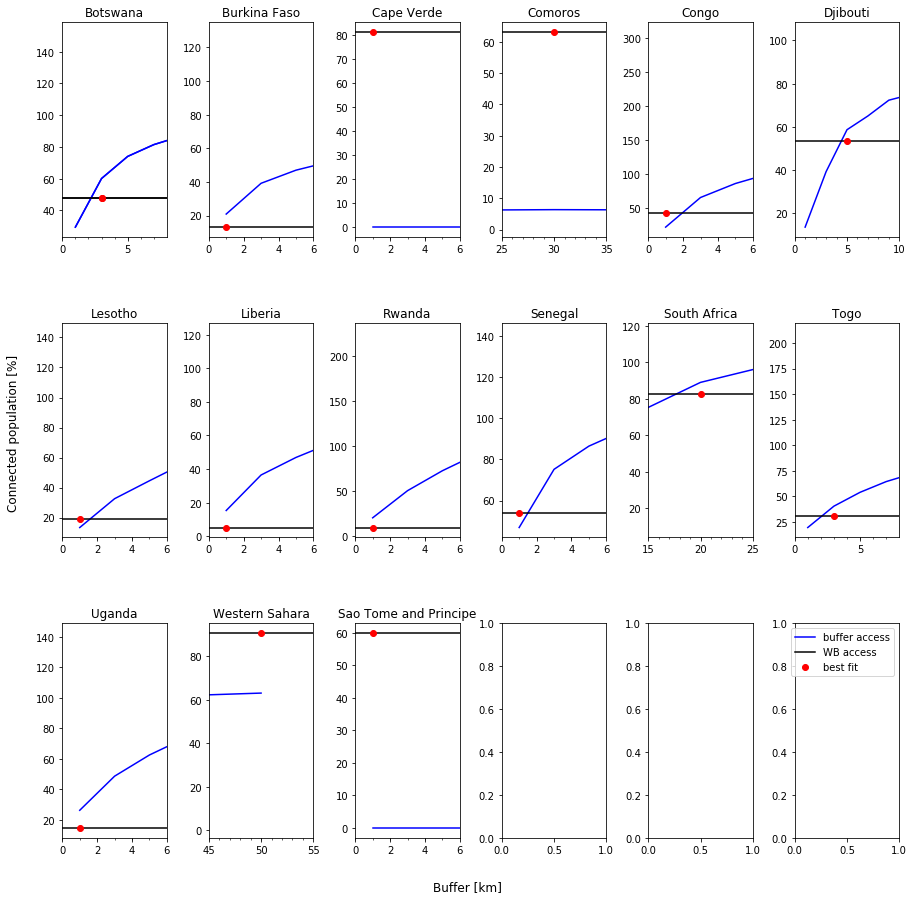

In [20]:
# Plot all data outside the tolerance level

fig, ax = plt.subplots(3, 6) #, sharex='col', sharey='row')
fig.set_size_inches(15,15)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

cols = [c for c in cb_norm_wb.columns if c.isnumeric()]
i = 0
j = 0
idx = beyond_tolerance[0]
for count in range(len(beyond_tolerance)+1):
    df = cb_norm_wb.loc[idx,cols].transpose().reset_index()
    
    # calculated buffer access:
    buff,=ax[i,j].plot(df.loc[:,'index'],df.loc[:,idx],color='blue')
    # note that df.loc[:,'index'] gives the buffer 
    # and df.loc[:,idx] gives the % of pop in the buffer  
    
    # wb access as a horizontal line:
    wb=ax[i,j].axhline(cb_norm_wb.loc[idx,'wb_access'], color='black')
    
    # access in best_fit buffer as a red dot
    bestfit,=ax[i,j].plot(int(cb_norm_wb.loc[idx,'buffer_km']),cb_norm_wb.loc[idx,'wb_access'], 'o', color='red')

    ax[i,j].set_title(cb_norm_wb.loc[idx,'COUNTRY'])
    ax[i,j].set_xlim(max(int(cb_norm_wb.loc[idx,'buffer_km'])-5,0),int(cb_norm_wb.loc[idx,'buffer_km'])+5)
    ax[i,j].set_xticks(range(max(int(cb_norm_wb.loc[idx,'buffer_km'])-5,0),int(cb_norm_wb.loc[idx,'buffer_km'])+5),\
                       range(max(int(cb_norm_wb.loc[idx,'buffer_km'])-5,0),int(cb_norm_wb.loc[idx,'buffer_km'])+5))
    if count!=0:
        if count//6 == count/6:
            i+=1
        if count//6 == count/6:
            j=0
        else:
            j+=1
    try: 
        idx = beyond_tolerance[count]
    except(IndexError):
        idx = idx

# put a legend
plt.legend([buff,wb,bestfit], ["buffer access","WB access","best fit"])

# Finally we print common axes titles
fig.text(0.5, 0.08, 'Buffer [km]', ha='center', va='center', fontsize=12)
fig.text(0.08, 0.5, 'Connected population [%]', ha='center', va='center', rotation='vertical', fontsize=12)



Looking at the plots above it's easy to figure out suitable buffer distances that would shift the the best-fit points closer to the intersection between black and blue lines. 

In some cases however there is just no grid in our input layer (e.g. Sao Tome) or the distance between populated centers and the nearest gridline is (way) above 50 km (e.g. Comoros). This mostly involoves small islands that are not representative for our purposes (would actually be good self-standing case studies), so we will just disregard them. The only exception is Western Sahara, but because the WB does not provide separate access data for this country (the black line in the plot is just the one for Morocco), we will simply assign to it the buffer distance of Morocco. 



In [21]:
for idx in beyond_tolerance: 
    print(idx, cb_norm_wb.loc[idx,'COUNTRY'])

3 Botswana
4 Burkina Faso
7 Cape Verde
10 Comoros
11 Congo
13 Djibouti
25 Lesotho
26 Liberia
37 Rwanda
38 Senegal
41 South Africa
45 Togo
47 Uganda
48 Western Sahara
51 Sao Tome and Principe


In [22]:
int(cb_norm_wb[cb_norm_wb.COUNTRY=='Morocco'].buffer_km.values[0])

20

In [23]:
# Let's make a dictionary with beyond_tollerance index : new buffer distance
new_buff_dic={3:2,
              4:0.5,
              7:0,
              10:0,
              11:2,
              13:4,
              25:1.5,
              26:0.5,
              37:0.5,
              38:1.5,
              41:17.5,
              45:2,
              47:0.5,
              48:int(cb_norm_wb[cb_norm_wb.COUNTRY=='Morocco'].buffer_km.values[0]),
              51:0
              } 

# Let's now make a list with old buffers for countries within tolerance 
# and new buffer for countries beyond tolerance. 
new_buff_list = []
for idx in cb_norm_wb.index:
    if idx in beyond_tolerance:
        new_buff_list.append(new_buff_dic[idx])
    else: 
        new_buff_list.append(int(cb_norm_wb.loc[idx,'buffer_km']))

# append the new buffers to the cb_norm_wb DF:
cb_norm_wb.loc[:,'buffer_5'] = new_buff_list
cb_norm_wb.head()

,COUNTRY,1,3,5,7,9,20,30,50,pop_raster,wb_access,buffer_km,b_access,delta_bwb,buffer_5
0,Algeria,26.251990,56.634076,71.014312,79.194636,83.332277,98.207271,105.213792,113.659837,2.505002e+07,98.884972,20,98.207271,-0.677701,20.0
1,Angola,9.792350,22.463411,28.713046,31.852158,34.712297,48.319056,58.365488,75.800449,1.552295e+07,33.514950,9,34.712297,1.197347,9.0
2,Benin,34.080144,59.878006,71.758876,80.018462,86.163806,110.386280,128.537492,161.772520,8.054520e+06,34.200000,1,34.080144,-0.119856,1.0
3,Botswana,29.483982,60.109250,74.047613,81.475546,86.595544,106.581732,119.660802,152.399101,1.336563e+06,47.793114,3,60.109250,12.316137,2.0
4,Burkina Faso,20.876007,39.183065,46.981857,52.149337,57.334188,81.584983,100.199804,129.161067,1.290668e+07,13.100000,1,20.876007,7.776007,0.5


In [24]:
# import country grid (in case it's not already imported)
grid = gpd.read_file(gis_dir+"country_grid.shp")
grid.head()

,ID,COUNTRY,geometry
0,1,Algeria,(LINESTRING (2930978.789678263 6820043.8091386...
1,2,Angola,(LINESTRING (3687515.311713001 1521170.9859224...
2,3,Angola,LINESTRING (3677895.79200978 2591628.267472052...
3,20,Benin,(LINESTRING (2578005.695706695 4080307.4511860...
4,21,Botswana,(LINESTRING (5110153.142133479 501730.68208632...


In [25]:
# merge the buffer_5 column into it:
df = cb_norm_wb.loc[:,['COUNTRY','buffer_5']]
grid = grid.merge(df, on='COUNTRY', how='inner')
# convert to meters and add values in a separate column that we will then use
# to create country-specific buffers
grid.loc[:,'buff_5_m'] = grid.loc[:,'buffer_5'] * 1000
grid

,ID,COUNTRY,geometry,buffer_5,buff_5_m
0,1,Algeria,(LINESTRING (2930978.789678263 6820043.8091386...,20.0,20000.0
1,2,Angola,(LINESTRING (3687515.311713001 1521170.9859224...,9.0,9000.0
2,3,Angola,LINESTRING (3677895.79200978 2591628.267472052...,9.0,9000.0
3,20,Benin,(LINESTRING (2578005.695706695 4080307.4511860...,1.0,1000.0
4,21,Botswana,(LINESTRING (5110153.142133479 501730.68208632...,2.0,2000.0
5,22,Burkina Faso,(LINESTRING (1890043.577764138 4478505.7524503...,0.5,500.0
6,23,Burundi,(LINESTRING (5581282.705708845 2833674.4296011...,3.0,3000.0
7,24,Cameroon,(LINESTRING (3578538.587810169 3611366.0104704...,3.0,3000.0
8,27,Cape Verde,LINESTRING (-82353.16684237774 4980102.4827796...,0.0,0.0
9,28,Cape Verde,(LINESTRING (-194449.2550688889 5253421.932171...,0.0,0.0


In [26]:
# export as shapefile
grid.to_file(gis_dir+"grid_buff.shp")

Now we import the new shapefile into QGIS and create a country-specific buffer using the values in column buff_5_m. We save the result as a buffer_5.shp, where the 5 indicates a tolerance of 5% (NOTE: in the dialog in QGIS use 'Assistent' and specify input and output min and max as 0 and 50000, respectively). We run zonal statistincs on it to count how many people there are in the buffers. 

## Current grid extension - iteration 1
Now we can import the buffer_5 file and check against the WB energy access data. The expectation is that all countries except for those in beyond_tolerance will be within 5% of the WB data. 

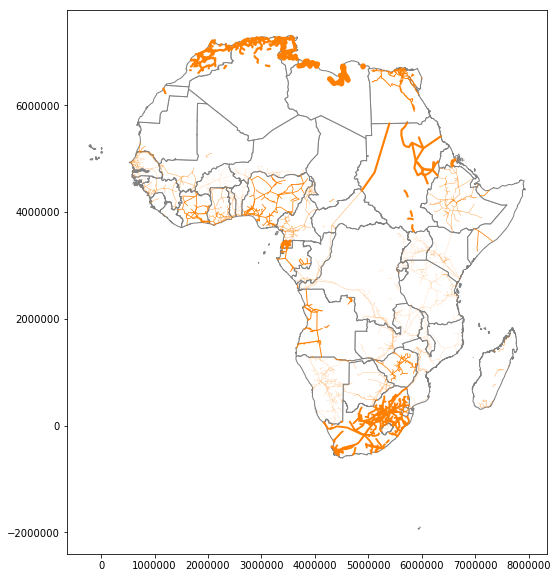

In [42]:
# First let's make a plot of the current buffers
buffered_grid = gpd.read_file(gis_dir+"buffers\\buffer_5.shp").loc[:,['ID','COUNTRY','geometry']]
ax = afr.plot(color='white', edgecolor='grey')
buffered_grid.plot(ax=ax, color='#ff7f00')
ax.get_figure().set_size_inches(10,10)

In [32]:
# import the file and select only relevant columns
b_5pt = gpd.read_file(gis_dir+"buffers\\buffer_5.shp").loc[:,['ID','COUNTRY','5pt_popsum']]
# make country-level overview
cb_5pt = b_5pt.groupby('COUNTRY').sum().reset_index()
cb_5pt.head()

,COUNTRY,5pt_popsum
0,Algeria,24600942.0
1,Angola,5388374.0
2,Benin,2744992.0
3,Botswana,636031.0
4,Burkina Faso,1577718.0


In [33]:
# merge pop data and normalize
cb_5pt_norm = cb_5pt.merge(cwtp, on='COUNTRY', how='outer')
cb_5pt_norm.loc[:,'5pt_norm'] = 100 * cb_5pt_norm.loc[:,'5pt_popsum'] / cb_5pt_norm.loc[:,'pop_raster']
cb_5pt_norm.head()

,COUNTRY,5pt_popsum,pop_raster,5pt_norm
0,Algeria,24600942.0,2.505002e+07,98.207271
1,Angola,5388374.0,1.552295e+07,34.712297
2,Benin,2744992.0,8.054520e+06,34.080144
3,Botswana,636031.0,1.336563e+06,47.587057
4,Burkina Faso,1577718.0,1.290668e+07,12.224044


In [34]:
# merge wb data
cb_5pt_norm = cb_5pt_norm.merge(acc, on='COUNTRY',how='left')
cb_5pt_norm.loc[:,'delta'] = cb_5pt_norm.loc[:,'5pt_norm']-cb_5pt_norm.loc[:,'wb_access']
cb_5pt_norm

,COUNTRY,5pt_popsum,pop_raster,5pt_norm,wb_access,delta
0,Algeria,24600942.0,2.505002e+07,98.207271,98.884972,-0.677701
1,Angola,5388374.0,1.552295e+07,34.712297,33.514950,1.197347
2,Benin,2744992.0,8.054520e+06,34.080144,34.200000,-0.119856
3,Botswana,636031.0,1.336563e+06,47.587057,47.793114,-0.206056
4,Burkina Faso,1577718.0,1.290668e+07,12.224044,13.100000,-0.875956
5,Burundi,409063.0,7.292878e+06,5.609075,5.300000,0.309075
6,Cameroon,9666200.0,1.718269e+07,56.255446,52.879360,3.376086
7,Cape Verde,0.0,0.000000e+00,NaN,81.100000,NaN
8,Central African Republic,311867.0,3.417062e+06,9.126759,9.800000,-0.673241
9,Chad,738352.0,9.362054e+06,7.886645,6.400000,1.486645


In [35]:
# let's check that it's all withinn 5% tolerance: 
cb_5pt_norm[abs(cb_5pt_norm.delta) > 5]

,COUNTRY,5pt_popsum,pop_raster,5pt_norm,wb_access,delta
10,Comoros,0.0,654769.0,0.000000,63.125820,-63.125820
48,Western Sahara,84043.0,287435.0,29.238958,90.811714,-61.572756


- Comoros: an island, small population, not representative for our purposes, so we neglect it
- Western Sahara: in the WB DB is not separated from Morocco, so we can disregard it (we give it the same buffer as Morocco)

In [36]:
# let's check which countries still need attention
cb_5pt_norm[cb_5pt_norm.delta.isna()]

,COUNTRY,5pt_popsum,pop_raster,5pt_norm,wb_access,delta
7,Cape Verde,0.0,0.0,NaN,81.100000,NaN
51,Sao Tome and Principe,NaN,140215.0,NaN,59.921047,NaN


- Cape Verde: an island, small population, not representative for our purposes, so we neglect it
- Sao Tome and Principe: an island, small population, not representative for our purposes, so we neglect it

# Grid extent projection
Final step is to project the size of the buffers to 2050. For this we use the same rates as the WTP projection. 

In [3]:
# import WTP projection data
wtp = gpd.read_file("C:\\Users\\dallalongaf\\OneDrive - TNO\\work\\2016 02 - TransRisk\\4 - energy access\\AFR_alt\\gis_layers\\off-grid_access\\wtp_vec.shp")
wtp.head()

,ID,CODE,COUNTRY,CNTRY,REGION,countrycou,countrysum,countrymea,Country Na,wtp-2010,...,pop2010s_1,pop2010c_2,pop2010s_2,pop2010c_3,pop2010s_3,pop2010c_4,pop2010s_4,pop_count,pop_sum,geometry
0,1,ALG,Algeria,Algeria,North Africa,2325210.0,407605757.0,175.298471,Algeria,142,...,24938644.0,2325210.0,25003877.0,2325210.0,25050021.0,2325210.0,25050021.0,2325210.0,25050021.0,"POLYGON ((1894589.42156076 6093196.823427028, ..."
1,2,ANG,Angola,Angola,Central Africa,1247523.0,248776781.0,199.416589,Angola,142,...,14084087.0,1247523.0,15306265.0,1247523.0,15306265.0,1247523.0,15306412.0,1247523.0,15307500.0,"POLYGON ((3809405.5247603 2283690.127493567, 3..."
2,3,ANG,Angola,Angola,Central Africa,7152.0,1699358.0,237.605984,Angola,142,...,209336.0,7152.0,214475.0,7152.0,214475.0,7152.0,214475.0,7152.0,214484.0,"POLYGON ((3744504.513407562 2674551.841173306,..."
3,4,ANG,Angola,Angola,Central Africa,102.0,21784.0,213.568627,Angola,142,...,0.0,102.0,0.0,102.0,0.0,102.0,0.0,102.0,0.0,"POLYGON ((3650051.721446254 1343900.192709396,..."
4,5,ANG,Angola,Angola,Central Africa,21.0,4608.0,219.428571,Angola,142,...,57.0,21.0,57.0,21.0,57.0,21.0,57.0,21.0,57.0,"POLYGON ((3755607.506678306 2543061.0734161, 3..."


In [4]:
# select only columns we're interested in
wtp = wtp[['ID','wtp-2010','wtp-2020','wtp-2030','wtp-2040','wtp-2050']]
wtp.head()

,ID,wtp-2010,wtp-2020,wtp-2030,wtp-2040,wtp-2050
0,1,142,168,204,243,283
1,2,142,177,233,299,366
2,3,142,177,233,299,366
3,4,142,177,233,299,366
4,5,142,177,233,299,366


In [5]:
wtp_coeff = wtp.set_index('ID')
#wtp_2010 = wtp_coeff.loc[:,'wtp-2010']
#for c in wtp_coeff.columns:
#    wtp_coeff.loc[:,c] = wtp_coeff.loc[:,c] / wtp_2010
wtp_coeff.head()

,wtp-2010,wtp-2020,wtp-2030,wtp-2040,wtp-2050
ID,,,,,
1,142,168,204,243,283
2,142,177,233,299,366
3,142,177,233,299,366
4,142,177,233,299,366
5,142,177,233,299,366


In [8]:
# Reimport buffer_5 and call it buff2010.
buff2010 = gpd.read_file(gis_dir+"grid_buff.shp")
buff2010.head()

,ID,COUNTRY,buffer_5,buff_5_m,geometry
0,1,Algeria,20.0,20000.0,(LINESTRING (2930978.789678263 6820043.8091386...
1,2,Angola,9.0,9000.0,(LINESTRING (3687515.311713001 1521170.9859224...
2,3,Angola,9.0,9000.0,LINESTRING (3677895.79200978 2591628.267472052...
3,20,Benin,1.0,1000.0,(LINESTRING (2578005.695706695 4080307.4511860...
4,21,Botswana,2.0,2000.0,(LINESTRING (5110153.142133479 501730.68208632...


In [9]:
# prepare a buff_prj DF
buff_prj = buff2010[['ID','COUNTRY','buff_5_m']].set_index('ID')
buff_prj.columns = ['COUNTRY','2010']
buff_prj.head()

,COUNTRY,2010
ID,,
1,Algeria,20000.0
2,Angola,9000.0
3,Angola,9000.0
20,Benin,1000.0
21,Botswana,2000.0


In [10]:
buff_prj = buff_prj.reset_index()
wtp_coeff = wtp_coeff.reset_index()#.drop('index',axis=1)
buff_prj = buff_prj.merge(wtp_coeff, on='ID', how='left')
#buff_prj.loc[:,'2020'] = buff_prj.loc[:,'2010'] + wtp_coeff.loc[:,'wtp-2020'] * 3.93
buff_prj.head()

,ID,COUNTRY,2010,wtp-2010,wtp-2020,wtp-2030,wtp-2040,wtp-2050
0,1,Algeria,20000.0,142,168,204,243,283
1,2,Angola,9000.0,142,177,233,299,366
2,3,Angola,9000.0,142,177,233,299,366
3,20,Benin,1000.0,132,175,225,278,337
4,21,Botswana,2000.0,81,98,117,144,170


In [11]:
for i in range(2020,2060,10):
    y = str(i)
    buff_prj.loc[:,y] = buff_prj.loc[:,'2010'] + 1000 * (buff_prj.loc[:,'wtp-%s'%y] - buff_prj.loc[:,'wtp-2010']) / 3.93
buff_prj.head()

,ID,COUNTRY,2010,wtp-2010,wtp-2020,wtp-2030,wtp-2040,wtp-2050,2020,2030,2040,2050
0,1,Algeria,20000.0,142,168,204,243,283,26615.776081,35776.081425,45699.745547,55877.862595
1,2,Angola,9000.0,142,177,233,299,366,17905.852417,32155.216285,48949.109415,65997.455471
2,3,Angola,9000.0,142,177,233,299,366,17905.852417,32155.216285,48949.109415,65997.455471
3,20,Benin,1000.0,132,175,225,278,337,11941.475827,24664.122137,38150.127226,53162.849873
4,21,Botswana,2000.0,81,98,117,144,170,6325.699746,11160.305344,18030.534351,24646.310433


In [12]:
# Keep only relevant columns
buff_prj = buff_prj[['ID','COUNTRY','2010','2020','2030','2040','2050']]
buff_prj.head()

,ID,COUNTRY,2010,2020,2030,2040,2050
0,1,Algeria,20000.0,26615.776081,35776.081425,45699.745547,55877.862595
1,2,Angola,9000.0,17905.852417,32155.216285,48949.109415,65997.455471
2,3,Angola,9000.0,17905.852417,32155.216285,48949.109415,65997.455471
3,20,Benin,1000.0,11941.475827,24664.122137,38150.127226,53162.849873
4,21,Botswana,2000.0,6325.699746,11160.305344,18030.534351,24646.310433


We now have a DF with countries and buffer projections up to 2050 (in meters). The IDs correspond to IDs of single grid segments in the original country_grid shapefile. We want to put everything into a gdf, together with the gridlines geometry and save as a shapefile for further processing in QGIS.

In [13]:
# import grid geometries
country_grid = gpd.read_file(gis_dir+"country_grid.shp")
country_grid.head()

,ID,COUNTRY,geometry
0,1,Algeria,(LINESTRING (2930978.789678263 6820043.8091386...
1,2,Angola,(LINESTRING (3687515.311713001 1521170.9859224...
2,3,Angola,LINESTRING (3677895.79200978 2591628.267472052...
3,20,Benin,(LINESTRING (2578005.695706695 4080307.4511860...
4,21,Botswana,(LINESTRING (5110153.142133479 501730.68208632...


In [14]:
# add buffer projections for every segment (ID) and store into new GDF
grid_buff_prj = country_grid.drop('COUNTRY',axis=1).merge(buff_prj, on='ID', how='outer')
grid_buff_prj.head()

,ID,geometry,COUNTRY,2010,2020,2030,2040,2050
0,1,(LINESTRING (2930978.789678263 6820043.8091386...,Algeria,20000.0,26615.776081,35776.081425,45699.745547,55877.862595
1,2,(LINESTRING (3687515.311713001 1521170.9859224...,Angola,9000.0,17905.852417,32155.216285,48949.109415,65997.455471
2,3,LINESTRING (3677895.79200978 2591628.267472052...,Angola,9000.0,17905.852417,32155.216285,48949.109415,65997.455471
3,20,(LINESTRING (2578005.695706695 4080307.4511860...,Benin,1000.0,11941.475827,24664.122137,38150.127226,53162.849873
4,21,(LINESTRING (5110153.142133479 501730.68208632...,Botswana,2000.0,6325.699746,11160.305344,18030.534351,24646.310433


In [15]:
# export to shapefile
grid_buff_prj.to_file(gis_dir+"grid_buff_prj.shp")

Next we import the new shapefile into QGIS and: 
- Use the buffer tool to create 5 new buffer files with buffer distances specified in the columns of grid_buff_prj;
- Use the intersection tool to intersect the buffers with the country boundaries, making sure to keep the 'ID' field of both layers. Then in the attribute table select only those features where the two inhereted IDs (normally named 'ID'and 'ID_2) are equal, and get rid of the rest. (The intersection operation will keep the parts of the buffer of a country that are contained within another country, because the corresponding country-boundary polygon is still part of the intersection layer. By only selecting the features that have ID = ID_2 we only keep the parts that fall within country-boundaries) - (Note that without this step the buffers will 'spill' into other countries, hence population living in those countries will be mistakenly counted when doing zonal stats);
- run zonal stats to obtain the population in the new, country-respecting buffers. 

We now import the resulting layers here for further processing. 

In [16]:
# import all new buffers
years = ['2010','2020','2030','2040','2050']
buffers = []
for y in years:
    buffers.append(gpd.read_file(gis_dir+"buffers\\buffer_%s_clip.shp"%y))
buffers[0].head()

,ID,COUNTRY,2010,popsum,geometry
0,1,Algeria,20000.0,23954018.0,(POLYGON ((2420144.374687384 7091913.138727172...
1,2,Angola,9000.0,5211306.0,"(POLYGON ((4631812.56194 2268224.24581, 462978..."
2,3,Angola,9000.0,70897.0,"POLYGON ((3667069.679430061 2634930.448643925,..."
3,20,Benin,1000.0,2737001.0,(POLYGON ((2495974.505721298 4295719.060625629...
4,21,Botswana,2000.0,624713.0,"(POLYGON ((4789069.04847 585205.43599, 4789570..."


In [17]:
# we only keep the population in the buffer and group by country
c_buffpop_list = []
for b in buffers:
    year = b.columns[2]
    df = b.groupby('COUNTRY').sum()['popsum'].reset_index()
    df.columns=['COUNTRY',year]
    c_buffpop_list.append(df)
c_buffpop_list[1].head()

,COUNTRY,2020
0,Algeria,25195250.0
1,Angola,6810032.0
2,Benin,6950648.0
3,Botswana,1059840.0
4,Burkina Faso,4747310.0


In [18]:
# let's merge them
c_buffpop = c_buffpop_list[0].merge(c_buffpop_list[1],on='COUNTRY',how='outer')
for b in c_buffpop_list[2:]:
    c_buffpop = c_buffpop.merge(b,on='COUNTRY',how='outer')
c_buffpop

,COUNTRY,2010,2020,2030,2040,2050
0,Algeria,23954018.0,25195250.0,26264758.0,26925266.0,27436486.0
1,Angola,5282203.0,6810032.0,8723462.0,10520967.0,11801945.0
2,Benin,2737001.0,6950648.0,8046353.0,8515030.0,8814685.0
3,Botswana,624713.0,1059840.0,1194267.0,1304214.0,1372357.0
4,Burkina Faso,1607366.0,4747310.0,5988503.0,6736907.0,7589474.0
5,Burundi,403321.0,537174.0,638633.0,921358.0,1098462.0
6,Cameroon,9562840.0,13233351.0,15862344.0,17520837.0,18377470.0
7,Central African Republic,312011.0,412306.0,599108.0,699261.0,789200.0
8,Chad,651549.0,948679.0,1152882.0,1311892.0,1379237.0
9,Congo,1407566.0,2885964.0,3097630.0,3284209.0,3451888.0


Now we need to normalize this. We first run zonal stats in QGIS on the corrected country boundary layer to get the 2010 pop per polyogn. Then we import it here, make a country-level table and use it to normalize the c_buffpop DF. 

In [19]:
# pop per country
afr = gpd.read_file(gis_dir+"afretep_etrs_countries_corrected.shp")
c_pop = afr[['COUNTRY','popsum']].groupby('COUNTRY').sum().reset_index()
c_pop.head()

,COUNTRY,popsum
0,Algeria,2.934346e+07
1,Angola,1.820212e+07
2,Benin,9.233573e+06
3,Botswana,1.528788e+06
4,Burkina Faso,1.509769e+07


In [20]:
c_pop = c_pop.set_index('COUNTRY')
c_buffpop_norm = c_buffpop.set_index('COUNTRY')
for col in c_buffpop_norm.columns:
    c_buffpop_norm.loc[:,col] = c_buffpop_norm.loc[:,col] / c_pop.loc[:,'popsum']
#c_buffpop_norm = c_buffpop_norm.dropna()
c_buffpop_norm

,2010,2020,2030,2040,2050
COUNTRY,,,,,
Algeria,0.816332,0.858633,0.895081,0.917590,0.935012
Angola,0.290197,0.374134,0.479255,0.578008,0.648383
Benin,0.296418,0.752758,0.871424,0.922181,0.954634
Botswana,0.408633,0.693255,0.781185,0.853103,0.897676
Burkina Faso,0.106464,0.314439,0.396650,0.446221,0.502691
Burundi,0.047653,0.063468,0.075456,0.108860,0.129786
Cameroon,0.475767,0.658381,0.789177,0.871690,0.914309
Central African Republic,0.079834,0.105496,0.153293,0.178919,0.201932
Chad,0.060105,0.087515,0.106352,0.121021,0.127233


Normalized population connected to the grid which is <= 1 for all countries. This is good, it means we are not counting people beyond country-boundaries.

In [21]:
# Before exporting to excel we merge with c_pop to have all the same countries 
# as in the original country-boundary shapefile, i.e same countries as in off-gridd access.
on_grid_acc = c_pop.reset_index()\
                   .drop('popsum',axis=1)\
                   .merge(c_buffpop_norm,on='COUNTRY',how='left')\
                   .fillna(0)
on_grid_acc

,COUNTRY,2010,2020,2030,2040,2050
0,Algeria,0.816332,0.858633,0.895081,0.917590,0.935012
1,Angola,0.290197,0.374134,0.479255,0.578008,0.648383
2,Benin,0.296418,0.752758,0.871424,0.922181,0.954634
3,Botswana,0.408633,0.693255,0.781185,0.853103,0.897676
4,Burkina Faso,0.106464,0.314439,0.396650,0.446221,0.502691
5,Burundi,0.047653,0.063468,0.075456,0.108860,0.129786
6,Cameroon,0.475767,0.658381,0.789177,0.871690,0.914309
7,Cape Verde,0.000000,0.000000,0.000000,0.000000,0.000000
8,Central African Republic,0.079834,0.105496,0.153293,0.178919,0.201932
9,Chad,0.060105,0.087515,0.106352,0.121021,0.127233


In [22]:
on_grid_acc.to_excel(gis_dir+"output\\on-grid_access.xlsx")